# RA Diagnosis Example - Machine Learning
https://blog.socialcops.com/technology/data-science/machine-learning-python/

In [1]:
import sys
sys.path.append('../')
sys.path.append('../modules/')
#print(sys.getsize())
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
from sklearn import __version__ as sk_vers
import EMR_functions as em
import re
import Visualize as vis



test_size = 0.5 # factor for splitting data

def test_classifier(clf):
    scores = model_selection.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))
    #return scores

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('pattern version:\t' + pat_vers)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.14.3
sklearn version:	0.19.1
pattern version:	3.6


## Step 1: Processing the dataset

In [2]:
def binarize(value):
    if value == 'j':
        return 'y'
    elif value == 'n':
        return 'n'
    elif value == 'p':
        return 'n'
    #return int(value != 'y')

radiag_df = pd.read_csv(r'annotation_v2_20190125.csv', index_col=0, sep="|", na_values=['NA'])
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x : binarize(x)) 
lemma_radiag_df = radiag_df.copy()
print(len(radiag_df))
radiag_df.head()

1361


,ID,DATUM,PATNR,XANTWOORD,Outcome,"j = ja, n= nee, p = possible (overlap geclasificeerd als possible, beginnende RA = possible, ""meest passend bij RA"" = p, eerder diagnose RA = j (tenzij behandelend reumatoloog dit actief in twijfel trekt))","N.B. zo af en toe krijg ik de indruk dat ws uit de rest van de file wel RA geextraheerd kan worden. Ik heb mij beperkt tot de tekst die in de conclusie staat. Daarin moet RA dus echt genoemd worden (of bv. ""voldoet aan de ACR2010 criteria""). Werkdiagnose = p"
8341,96865216,21-10-2011,4907,psoa in remissie,n,NaN,NaN
6009,96834035,27-09-2011,6733,1 . slotklachten beide knieen dd meniscusprobl...,n,NaN,NaN
28669,98580639,07-08-2015,10697,polyartritis,n,NaN,NaN
2850,96694093,17-05-2011,13818,"1 . artritis psoriatica , twee gewrichten onst...",n,NaN,NaN
9267,97017591,06-03-2012,18820,rustige jia ^meerdere ok ' s te radbout zh,n,NaN,NaN


### Clean Data

In [3]:
def simpleCleaning(sentence, lemma=False): # Keep in mind: this function removes numbers
    sticky_chars = r'([!#?,.:";@\-\+\\/&=$\]\[<>\'^\*`â€™\(\)\d])'
    sentence = re.sub(sticky_chars, r' ', sentence)
    sentence = sentence.lower()
    if (lemma):
        return em.lemmatizingText(sentence)
    else :
        return sentence

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : simpleCleaning(x))
lemma_radiag_df['XANTWOORD'] = lemma_radiag_df['XANTWOORD'].apply(lambda x : simpleCleaning(x, lemma=True))
lemma_radiag_df.head(5)

,ID,DATUM,PATNR,XANTWOORD,Outcome,"j = ja, n= nee, p = possible (overlap geclasificeerd als possible, beginnende RA = possible, ""meest passend bij RA"" = p, eerder diagnose RA = j (tenzij behandelend reumatoloog dit actief in twijfel trekt))","N.B. zo af en toe krijg ik de indruk dat ws uit de rest van de file wel RA geextraheerd kan worden. Ik heb mij beperkt tot de tekst die in de conclusie staat. Daarin moet RA dus echt genoemd worden (of bv. ""voldoet aan de ACR2010 criteria""). Werkdiagnose = p"
8341,96865216,21-10-2011,4907,psoa in remissie,n,NaN,NaN
6009,96834035,27-09-2011,6733,slotklacht beide knie dd meniscusprobleem eerd...,n,NaN,NaN
28669,98580639,07-08-2015,10697,polyartritis,n,NaN,NaN
2850,96694093,17-05-2011,13818,artritis psoriatica twee gewricht onstook ferr...,n,NaN,NaN
9267,97017591,06-03-2012,18820,rustig jia meerdere ok te radbout zh,n,NaN,NaN


### Make test & trainingsset

In [11]:
X = lemma_radiag_df['XANTWOORD'].values
y = lemma_radiag_df[['ID', 'Outcome']].values

X_train, X_test, y_full_train, y_full_test = model_selection.train_test_split(X,y,test_size=test_size, random_state=777)
y_train = y_full_train[range(len(y_full_train)),1]
y_test = y_full_test[range(len(y_full_test)),1]

d_test = {'XANTWOORD': X_test, 'Outcome': y_test, 'ID': y_full_test[range(len(y_full_test)),0]}
df_test = pd.DataFrame(d_test)

### Visualize distribution -> trainingsset

(469, 211)


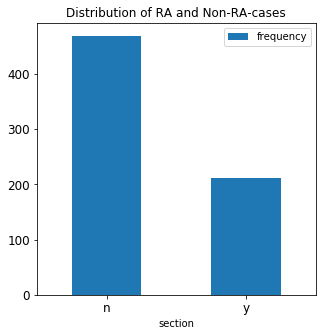

In [17]:
from collections import Counter

labels, values = zip(*Counter(y_train).items())
print(values)

df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

In [31]:
count = 0
for index, row in test_df.iterrows():
    regexp = re.compile(r'\b((rheumatoid|reumatoide)\s(arthritis|artritis)|ra)\b')
    if row['Outcome'] == 'n' and regexp.search(row['XANTWOORD']):
        count += 1
print(count)

195


# #1 Rule Based approach
## Step 1: Initialize list of modifiers & targets

- Targets = also known as entities
- Modifiers = terms that influence the meaning of the sentence (like negation terms)

In [18]:
from pyConTextNLP import itemData
import pyConTextNLP
from textblob import TextBlob
import re
print(itemData)

cop = em.ContextProcessing(df_test, path_mod='../corpus/modifiersNL.yml', \
                 path_tar='../corpus/targets.yml')
df_predict = cop.predict_proba()
cut_off = 0.6
df_predict['PRED'] = df_predict['PRED_PROBA'].apply(lambda x: 'y' if float(x) >= float(cut_off) else 'n')
#print(df_predict['PRED'].tolist())

print('yes')

def simple_rulebased(report):
    regexp = re.compile(r'\b((rheumatoid|reumatoide)\s(arthritis|artritis)|ra)\b')
    if regexp.search(report):
        return 'y'
    else :
        return 'n'
l_context= test_df['XANTWOORD'].apply(lambda x: simple_rulebased(str(x))).tolist()
df_pred_simple = df_test.copy()
df_pred_simple = df_pred_simple.assign(PRED2=[l_context[x][0] for x in range(len(l_context))])
df_pred_simple.head()

<module 'pyConTextNLP.itemData' from 'E:\\modules\\Anaconda\\Program\\lib\\site-packages\\pyConTextNLP\\itemData.py'>
yes


,XANTWOORD,Outcome,ID,PRED2
0,oligoartritis pip gewricht hand bdz bij pen me...,n,97479466,n
1,alleen de acuut faas recatie zullen een aanwij...,n,97672540,n
2,jarig patiente bekend met dementie met subacut...,n,98368213,y
3,ap rustig onder mtx po mg,n,96721813,n
4,pte met ra die elders onder beh zijn met mtx e...,y,99533532,y


## Step 2: Predict Context according to the predefined rules

Cut off:  0.42500000000000004


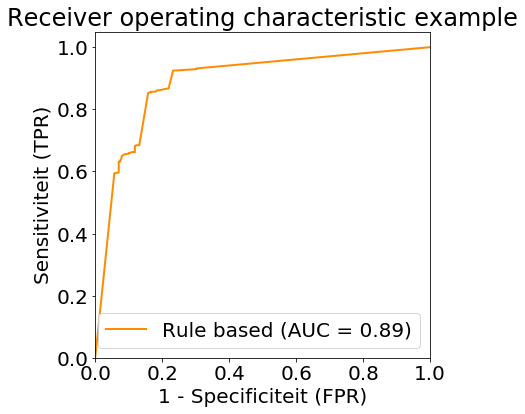

In [30]:
def binarize(value):
    return int(value != 'y')

# RA needs to be binarized first y -> 0 n -> 1 
if 'y' in list(df_predict['Outcome'].unique()):
    df_predict['Outcome'] = df_predict['Outcome'].apply(lambda x : binarize(x)) 
fpr, tpr, thresholds = metrics.roc_curve(df_predict['Outcome'], 1-df_predict['PRED_PROBA'], pos_label=None, sample_weight=None, drop_intermediate=True)
plt.figure(figsize=(6,6))
vis.append_roc_curve('ROC curve for different classification methods', 'Rule based', fpr, tpr, plt)
roc = pd.DataFrame({'fpr' : pd.Series(fpr),'tpr' : pd.Series(tpr), '1-fpr' : pd.Series(1-fpr), 'tf' : pd.Series(tpr - (1-fpr)), 'thresholds' : pd.Series(thresholds)})
cut_off = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
print('Cut off: ', cut_off)
plt.show()

In [104]:
import scipy.stats as ss
import collections

def binarize(value):
    return int(value == 'y')

if 'y' in list(df_pred_simple['Outcome'].unique()):
    df_pred_simple['Outcome'] = df_pred_simple['Outcome'].apply(lambda x : binarize(x))
    df_pred_simple['PRED2'] = df_pred_simple['PRED2'].apply(lambda x : binarize(x))

d_perf = {}

count = 0
for index, row in df_pred_simple.iterrows():
    d_perf[count] = [row['PRED2'], row['Outcome']]
    count += 1
    
    
def func(value):
    #print(value[1][0])
    return value[1][0]
orderedDict = collections.OrderedDict(sorted(d_perf.items(), key=lambda k: func(k), reverse=True))

# sorted via predictions
l_sorted_pred= []
l_sorted_true = []
for x in orderedDict.items():
    l_sorted_pred.append(x[1][0])
    l_sorted_true.append(x[1][1]) 
    
# print(l_sorted_pred)
# print(l_sorted_true)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## Step 3: Performance of the Rule Based Approach

y = 0 because the confusion matrix orders the groups on numbers

### Confusion Matrix - Rule Based Approach

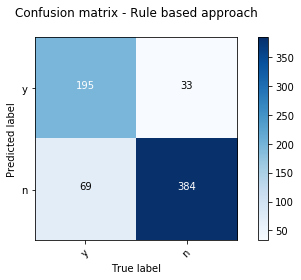

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd 
import re

cut_off = 0.6

df_predict['PRED'] = df_predict['PRED_PROBA'].apply(lambda x: 0 if float(x) >= float(cut_off) else 1) # y -> 0 and n -> 1

cm = confusion_matrix(df_predict['Outcome'], df_predict['PRED'])

plt = vis.plot_confusion_matrix(cm, ['y', 'n'], title="Confusion matrix - Rule based approach\n")
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

### Confusion Matrix - Exact word matching

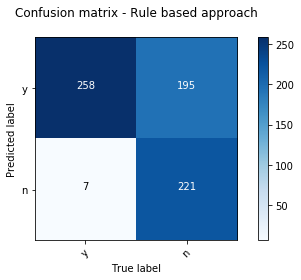

In [35]:

cm = confusion_matrix(df_pred_simple['Outcome'], df_pred_simple['PRED2'])

plt = vis.plot_confusion_matrix(cm, ['y', 'n'], title="Confusion matrix - Rule based approach\n")
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

#### Binarize Rule based -> predictions for final comparison with ML-methods

In [30]:
from sklearn import metrics
def binarize(value):
    return int(value == 'y')
df_predict['RA'] = df_predict['RA'].apply(lambda x : binarize(x))
df_predict['PRED'] = df_predict['PRED'].apply(lambda x : binarize(x))


# #2 Machine Learning approach

## Step 1: Processing the data
### Converting words to numerical feature vectors

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
X_train_counts.shape

(500, 1899)

#### Reduce weightage stopword weights

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer() ## reduce the occurrence of common words (stopwords)  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
# shape is the same prob. already happens in previous step

(500, 1899)

## Step 2: Building the Pipeline & Fitting the Models

First: Import important modules

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree

### Different options:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [32]:
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ske.GradientBoostingClassifier(random_state=123))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(solver='lbfgs', random_state=123)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', tree.DecisionTreeClassifier(random_state=123)),
            ]),
    # SVM 4 - SVC probability
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=123, probability=True)),
            ]),
    # SVM - 5
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, random_state=123,
                    max_iter=5, tol=None)),
            ])
    ]


## Step 3: Performance of the models

### Calculate TPR & FPR range for Decision Tree
1. The binary 'probabilities' (l_sorted_pred) are sorted from 1's to 0's -> \[1, 1, 1, 1, 1, 0, 0, 0, 0\]
2. The associated true labels (l_sorted_true) are then used as input in the R-script to create a binary ROC


In [28]:
import collections
text_clf = pipe_list[3].fit(X_train, y_train)

pred = text_clf.predict(X_test)
b_pred = []
for x in pred:
    if x == 'y':
        b_pred.append(1)
    elif x == 'n':
        b_pred.append(0)
d_perf_dt = {}

def binarize(value):
    return int(value == 'y')

count = 0
for index, row in df_pred_simple.iterrows():
    d_perf_dt[count] = [b_pred[count], binarize(row['Outcome'])]
    count += 1
    
def func(value):
    return value[1][0]
orderedDict = collections.OrderedDict(sorted(d_perf_dt.items(), key=lambda k: func(k), reverse=True))

l_sorted_pred= []
l_sorted_true = []
for x in orderedDict.items():
    l_sorted_pred.append(x[1][0])
    l_sorted_true.append(x[1][1]) 
#print(l_sorted_true)
#print(l_sorted_pred)


### ROC curve for all applied methods 
To compare Machine Learning (ML) methods with the Rule Based approach

#### Decision tree - TPR and FPR range (output from external R-script)

In [21]:
#print(pred)
fpr_dt = [0, 0.0022075055187638, 0.00441501103752759, 0.00441501103752759, 0.00662251655629139, 0.00662251655629139, 0.00883002207505519, 0.011037527593819, 0.0132450331125828, 0.0132450331125828, 0.0132450331125828, 0.0132450331125828, 0.0154525386313466, 0.0176600441501104, 0.0198675496688742, 0.0198675496688742, 0.022075055187638, 0.022075055187638, 0.022075055187638, 0.0242825607064018, 0.0264900662251656, 0.0286975717439294, 0.0309050772626932, 0.033112582781457, 0.033112582781457, 0.0353200883002208, 0.0375275938189845, 0.0397350993377483, 0.0397350993377483, 0.0397350993377483, 0.0419426048565121, 0.0419426048565121, 0.0441501103752759, 0.0463576158940397, 0.0485651214128035, 0.0485651214128035, 0.0485651214128035, 0.0507726269315673, 0.0507726269315673, 0.0507726269315673, 0.0507726269315673, 0.0529801324503311, 0.0551876379690949, 0.0573951434878587, 0.0596026490066225, 0.0618101545253863, 0.0618101545253863, 0.0640176600441501, 0.0662251655629139, 0.0662251655629139, 0.0684326710816777, 0.0684326710816777, 0.0706401766004415, 0.0728476821192053, 0.0750551876379691, 0.0772626931567329, 0.0794701986754967, 0.0794701986754967, 0.0794701986754967, 0.0816777041942605, 0.0838852097130243, 0.0860927152317881, 0.0883002207505519, 0.0905077262693157, 0.0905077262693157, 0.0927152317880795, 0.0949227373068433, 0.0971302428256071, 0.0993377483443709, 0.101545253863135, 0.103752759381898, 0.105960264900662, 0.108167770419426, 0.11037527593819, 0.112582781456954, 0.112582781456954, 0.112582781456954, 0.112582781456954, 0.112582781456954, 0.114790286975717, 0.114790286975717, 0.114790286975717, 0.114790286975717, 0.114790286975717, 0.116997792494481, 0.119205298013245, 0.121412803532009, 0.123620309050773, 0.125827814569536, 0.1280353200883, 0.130242825607064, 0.132450331125828, 0.132450331125828, 0.134657836644592, 0.136865342163355, 0.136865342163355, 0.139072847682119, 0.139072847682119, 0.141280353200883, 0.143487858719647, 0.143487858719647, 0.143487858719647, 0.145695364238411, 0.145695364238411, 0.145695364238411, 0.147902869757174, 0.150110375275938, 0.152317880794702, 0.152317880794702, 0.154525386313466, 0.15673289183223, 0.15673289183223, 0.158940397350993, 0.161147902869757, 0.163355408388521, 0.165562913907285, 0.165562913907285, 0.167770419426049, 0.167770419426049, 0.169977924944812, 0.169977924944812, 0.172185430463576, 0.17439293598234, 0.176600441501104, 0.176600441501104, 0.176600441501104, 0.178807947019868, 0.181015452538631, 0.183222958057395, 0.183222958057395, 0.183222958057395, 0.185430463576159, 0.187637969094923, 0.187637969094923, 0.187637969094923, 0.189845474613687, 0.19205298013245, 0.194260485651214, 0.194260485651214, 0.194260485651214, 0.196467991169978, 0.198675496688742, 0.200883002207506, 0.200883002207506, 0.203090507726269, 0.205298013245033, 0.205298013245033, 0.205298013245033, 0.207505518763797, 0.209713024282561, 0.211920529801325, 0.214128035320088, 0.216335540838852, 0.218543046357616, 0.218543046357616, 0.22075055187638, 0.22075055187638, 0.222958057395143, 0.225165562913907, 0.225165562913907, 0.227373068432671, 0.229580573951435, 0.229580573951435, 0.231788079470199, 0.231788079470199, 0.231788079470199, 0.233995584988962, 0.236203090507726, 0.236203090507726, 0.23841059602649, 0.23841059602649, 0.23841059602649, 0.240618101545254, 0.242825607064018, 0.245033112582781, 0.245033112582781, 0.247240618101545, 0.247240618101545, 0.249448123620309, 0.249448123620309, 0.251655629139073, 0.251655629139073, 0.253863134657837, 0.2560706401766, 0.258278145695364, 0.260485651214128, 0.260485651214128, 0.262693156732892, 0.262693156732892, 0.264900662251656, 0.267108167770419, 0.269315673289183, 0.271523178807947, 0.271523178807947, 0.273730684326711, 0.275938189845475, 0.275938189845475, 0.278145695364238, 0.278145695364238, 0.280353200883002, 0.282560706401766, 0.282560706401766, 0.28476821192053, 0.28476821192053, 0.286975717439294, 0.289183222958057, 0.289183222958057, 0.289183222958057, 0.291390728476821, 0.293598233995585, 0.293598233995585, 0.295805739514349, 0.298013245033113, 0.300220750551876, 0.30242825607064, 0.304635761589404, 0.304635761589404, 0.306843267108168, 0.309050772626932, 0.311258278145695, 0.311258278145695, 0.313465783664459, 0.315673289183223, 0.317880794701987, 0.317880794701987, 0.320088300220751, 0.320088300220751, 0.322295805739514, 0.322295805739514, 0.322295805739514, 0.322295805739514, 0.322295805739514, 0.324503311258278, 0.326710816777042, 0.328918322295806, 0.328918322295806, 0.33112582781457, 0.333333333333333, 0.335540838852097, 0.337748344370861, 0.339955849889625, 0.342163355408389, 0.344370860927152, 0.346578366445916, 0.346578366445916, 0.346578366445916, 0.34878587196468, 0.350993377483444, 0.350993377483444, 0.353200883002208, 0.353200883002208, 0.355408388520971, 0.355408388520971, 0.355408388520971, 0.357615894039735, 0.359823399558499, 0.362030905077263, 0.364238410596026, 0.364238410596026, 0.36644591611479, 0.36644591611479, 0.368653421633554, 0.370860927152318, 0.370860927152318, 0.373068432671082, 0.373068432671082, 0.373068432671082, 0.373068432671082, 0.375275938189845, 0.377483443708609, 0.377483443708609, 0.379690949227373, 0.379690949227373, 0.379690949227373, 0.381898454746137, 0.381898454746137, 0.384105960264901, 0.386313465783664, 0.388520971302428, 0.390728476821192, 0.392935982339956, 0.39514348785872, 0.397350993377483, 0.399558498896247, 0.401766004415011, 0.401766004415011, 0.403973509933775, 0.403973509933775, 0.406181015452539, 0.408388520971302, 0.410596026490066, 0.410596026490066, 0.41280353200883, 0.415011037527594, 0.417218543046358, 0.419426048565121, 0.421633554083885, 0.423841059602649, 0.423841059602649, 0.426048565121413, 0.428256070640177, 0.43046357615894, 0.432671081677704, 0.432671081677704, 0.434878587196468, 0.437086092715232, 0.437086092715232, 0.439293598233996, 0.439293598233996, 0.441501103752759, 0.441501103752759, 0.443708609271523, 0.445916114790287, 0.448123620309051, 0.450331125827815, 0.450331125827815, 0.452538631346578, 0.454746136865342, 0.456953642384106, 0.45916114790287, 0.461368653421634, 0.463576158940397, 0.465783664459161, 0.467991169977925, 0.467991169977925, 0.470198675496689, 0.470198675496689, 0.470198675496689, 0.472406181015453, 0.474613686534216, 0.47682119205298, 0.479028697571744, 0.481236203090508, 0.483443708609272, 0.485651214128035, 0.487858719646799, 0.487858719646799, 0.487858719646799, 0.490066225165563, 0.492273730684327, 0.494481236203091, 0.494481236203091, 0.494481236203091, 0.494481236203091, 0.496688741721854, 0.496688741721854, 0.496688741721854, 0.498896247240618, 0.498896247240618, 0.501103752759382, 0.501103752759382, 0.503311258278146, 0.503311258278146, 0.503311258278146, 0.50551876379691, 0.507726269315673, 0.509933774834437, 0.509933774834437, 0.512141280353201, 0.514348785871965, 0.516556291390728, 0.518763796909492, 0.520971302428256, 0.52317880794702, 0.525386313465784, 0.527593818984547, 0.527593818984547, 0.527593818984547, 0.529801324503311, 0.532008830022075, 0.532008830022075, 0.532008830022075, 0.532008830022075, 0.534216335540839, 0.534216335540839, 0.536423841059603, 0.538631346578366, 0.54083885209713, 0.54083885209713, 0.543046357615894, 0.545253863134658, 0.547461368653422, 0.549668874172185, 0.551876379690949, 0.554083885209713, 0.556291390728477, 0.556291390728477, 0.556291390728477, 0.558498896247241, 0.560706401766004, 0.562913907284768, 0.565121412803532, 0.567328918322296, 0.567328918322296, 0.56953642384106, 0.571743929359823, 0.573951434878587, 0.576158940397351, 0.578366445916115, 0.580573951434879, 0.582781456953642, 0.584988962472406, 0.584988962472406, 0.58719646799117, 0.589403973509934, 0.591611479028698, 0.591611479028698, 0.593818984547461, 0.596026490066225, 0.596026490066225, 0.598233995584989, 0.600441501103753, 0.602649006622517, 0.60485651214128, 0.60485651214128, 0.60485651214128, 0.60485651214128, 0.607064017660044, 0.609271523178808, 0.611479028697572, 0.611479028697572, 0.613686534216336, 0.615894039735099, 0.618101545253863, 0.620309050772627, 0.622516556291391, 0.624724061810154, 0.624724061810154, 0.626931567328918, 0.626931567328918, 0.629139072847682, 0.631346578366446, 0.63355408388521, 0.635761589403974, 0.637969094922737, 0.640176600441501, 0.640176600441501, 0.642384105960265, 0.642384105960265, 0.644591611479029, 0.646799116997792, 0.649006622516556, 0.65121412803532, 0.653421633554084, 0.655629139072848, 0.657836644591612, 0.660044150110375, 0.662251655629139, 0.664459161147903, 0.666666666666667, 0.66887417218543, 0.671081677704194, 0.671081677704194, 0.671081677704194, 0.673289183222958, 0.675496688741722, 0.677704194260486, 0.679911699779249, 0.682119205298013, 0.684326710816777, 0.686534216335541, 0.686534216335541, 0.686534216335541, 0.688741721854305, 0.690949227373068, 0.690949227373068, 0.693156732891832, 0.695364238410596, 0.695364238410596, 0.69757174392936, 0.699779249448124, 0.701986754966887, 0.704194260485651, 0.706401766004415, 0.706401766004415, 0.706401766004415, 0.706401766004415, 0.708609271523179, 0.710816777041943, 0.713024282560706, 0.713024282560706, 0.71523178807947, 0.71523178807947, 0.717439293598234, 0.719646799116998, 0.721854304635762, 0.724061810154525, 0.726269315673289, 0.726269315673289, 0.726269315673289, 0.728476821192053, 0.730684326710817, 0.732891832229581, 0.735099337748344, 0.735099337748344, 0.737306843267108, 0.739514348785872, 0.739514348785872, 0.741721854304636, 0.7439293598234, 0.746136865342163, 0.748344370860927, 0.750551876379691, 0.750551876379691, 0.752759381898455, 0.752759381898455, 0.752759381898455, 0.752759381898455, 0.754966887417219, 0.757174392935982, 0.757174392935982, 0.757174392935982, 0.759381898454746, 0.76158940397351, 0.763796909492274, 0.763796909492274, 0.766004415011038, 0.768211920529801, 0.770419426048565, 0.772626931567329, 0.774834437086093, 0.777041942604856, 0.77924944812362, 0.781456953642384, 0.781456953642384, 0.783664459161148, 0.783664459161148, 0.783664459161148, 0.785871964679912, 0.785871964679912, 0.785871964679912, 0.788079470198676, 0.790286975717439, 0.790286975717439, 0.792494481236203, 0.794701986754967, 0.796909492273731, 0.796909492273731, 0.799116997792494, 0.799116997792494, 0.799116997792494, 0.799116997792494, 0.801324503311258, 0.803532008830022, 0.805739514348786, 0.80794701986755, 0.810154525386313, 0.812362030905077, 0.812362030905077, 0.814569536423841, 0.816777041942605, 0.818984547461369, 0.821192052980132, 0.821192052980132, 0.823399558498896, 0.82560706401766, 0.827814569536424, 0.830022075055188, 0.832229580573951, 0.834437086092715, 0.836644591611479, 0.836644591611479, 0.836644591611479, 0.838852097130243, 0.838852097130243, 0.841059602649007, 0.841059602649007, 0.84326710816777, 0.84326710816777, 0.84326710816777, 0.84326710816777, 0.845474613686534, 0.847682119205298, 0.847682119205298, 0.849889624724062, 0.849889624724062, 0.849889624724062, 0.849889624724062, 0.849889624724062, 0.849889624724062, 0.852097130242826, 0.852097130242826, 0.854304635761589, 0.854304635761589, 0.856512141280353, 0.858719646799117, 0.858719646799117, 0.858719646799117, 0.860927152317881, 0.860927152317881, 0.860927152317881, 0.863134657836645, 0.865342163355408, 0.865342163355408, 0.867549668874172, 0.867549668874172, 0.869757174392936, 0.869757174392936, 0.8719646799117, 0.8719646799117, 0.874172185430464, 0.874172185430464, 0.874172185430464, 0.874172185430464, 0.876379690949227, 0.878587196467991, 0.880794701986755, 0.880794701986755, 0.883002207505519, 0.885209713024283, 0.885209713024283, 0.887417218543046, 0.88962472406181, 0.891832229580574, 0.894039735099338, 0.896247240618102, 0.898454746136865, 0.898454746136865, 0.898454746136865, 0.900662251655629, 0.902869757174393, 0.905077262693157, 0.907284768211921, 0.909492273730684, 0.911699779249448, 0.913907284768212, 0.916114790286976, 0.916114790286976, 0.91832229580574, 0.91832229580574, 0.920529801324503, 0.920529801324503, 0.920529801324503, 0.922737306843267, 0.924944812362031, 0.924944812362031, 0.927152317880795, 0.927152317880795, 0.927152317880795, 0.929359823399558, 0.929359823399558, 0.931567328918322, 0.933774834437086, 0.933774834437086, 0.93598233995585, 0.938189845474614, 0.938189845474614, 0.940397350993378, 0.942604856512141, 0.944812362030905, 0.947019867549669, 0.949227373068433, 0.951434878587196, 0.951434878587196, 0.95364238410596, 0.95364238410596, 0.955849889624724, 0.958057395143488, 0.960264900662252, 0.962472406181015, 0.964679911699779, 0.964679911699779, 0.966887417218543, 0.966887417218543, 0.969094922737307, 0.969094922737307, 0.971302428256071, 0.973509933774834, 0.973509933774834, 0.975717439293598, 0.977924944812362, 0.980132450331126, 0.98233995584989, 0.984547461368653, 0.986754966887417, 0.988962472406181, 0.991169977924945, 0.991169977924945, 0.993377483443709, 0.995584988962472, 0.997792494481236, 1]
tpr_dt = [0, 0, 0, 0.0043859649122807, 0.0043859649122807, 0.0087719298245614, 0.0087719298245614, 0.0087719298245614, 0.0087719298245614, 0.0131578947368421, 0.0175438596491228, 0.0219298245614035, 0.0219298245614035, 0.0219298245614035, 0.0219298245614035, 0.0263157894736842, 0.0263157894736842, 0.0307017543859649, 0.0350877192982456, 0.0350877192982456, 0.0350877192982456, 0.0350877192982456, 0.0350877192982456, 0.0350877192982456, 0.0394736842105263, 0.0394736842105263, 0.0394736842105263, 0.0394736842105263, 0.043859649122807, 0.0482456140350877, 0.0482456140350877, 0.0526315789473684, 0.0526315789473684, 0.0526315789473684, 0.0526315789473684, 0.0570175438596491, 0.0614035087719298, 0.0614035087719298, 0.0657894736842105, 0.0701754385964912, 0.0745614035087719, 0.0745614035087719, 0.0745614035087719, 0.0745614035087719, 0.0745614035087719, 0.0745614035087719, 0.0789473684210526, 0.0789473684210526, 0.0789473684210526, 0.0833333333333333, 0.0833333333333333, 0.087719298245614, 0.087719298245614, 0.087719298245614, 0.087719298245614, 0.087719298245614, 0.087719298245614, 0.0921052631578947, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.100877192982456, 0.105263157894737, 0.109649122807018, 0.114035087719298, 0.118421052631579, 0.118421052631579, 0.12280701754386, 0.12719298245614, 0.131578947368421, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.135964912280702, 0.140350877192982, 0.140350877192982, 0.140350877192982, 0.144736842105263, 0.144736842105263, 0.149122807017544, 0.149122807017544, 0.149122807017544, 0.153508771929825, 0.157894736842105, 0.157894736842105, 0.162280701754386, 0.166666666666667, 0.166666666666667, 0.166666666666667, 0.166666666666667, 0.171052631578947, 0.171052631578947, 0.171052631578947, 0.175438596491228, 0.175438596491228, 0.175438596491228, 0.175438596491228, 0.175438596491228, 0.179824561403509, 0.179824561403509, 0.184210526315789, 0.184210526315789, 0.18859649122807, 0.18859649122807, 0.18859649122807, 0.18859649122807, 0.192982456140351, 0.197368421052632, 0.197368421052632, 0.197368421052632, 0.197368421052632, 0.201754385964912, 0.206140350877193, 0.206140350877193, 0.206140350877193, 0.210526315789474, 0.214912280701754, 0.214912280701754, 0.214912280701754, 0.214912280701754, 0.219298245614035, 0.223684210526316, 0.223684210526316, 0.223684210526316, 0.223684210526316, 0.228070175438596, 0.228070175438596, 0.228070175438596, 0.232456140350877, 0.236842105263158, 0.236842105263158, 0.236842105263158, 0.236842105263158, 0.236842105263158, 0.236842105263158, 0.236842105263158, 0.241228070175439, 0.241228070175439, 0.245614035087719, 0.245614035087719, 0.245614035087719, 0.25, 0.25, 0.25, 0.254385964912281, 0.254385964912281, 0.258771929824561, 0.263157894736842, 0.263157894736842, 0.263157894736842, 0.267543859649123, 0.267543859649123, 0.271929824561404, 0.276315789473684, 0.276315789473684, 0.276315789473684, 0.276315789473684, 0.280701754385965, 0.280701754385965, 0.285087719298246, 0.285087719298246, 0.289473684210526, 0.289473684210526, 0.293859649122807, 0.293859649122807, 0.293859649122807, 0.293859649122807, 0.293859649122807, 0.298245614035088, 0.298245614035088, 0.302631578947368, 0.302631578947368, 0.302631578947368, 0.302631578947368, 0.302631578947368, 0.307017543859649, 0.307017543859649, 0.307017543859649, 0.31140350877193, 0.31140350877193, 0.315789473684211, 0.315789473684211, 0.315789473684211, 0.320175438596491, 0.320175438596491, 0.324561403508772, 0.324561403508772, 0.324561403508772, 0.328947368421053, 0.333333333333333, 0.333333333333333, 0.333333333333333, 0.337719298245614, 0.337719298245614, 0.337719298245614, 0.337719298245614, 0.337719298245614, 0.337719298245614, 0.342105263157895, 0.342105263157895, 0.342105263157895, 0.342105263157895, 0.346491228070175, 0.346491228070175, 0.346491228070175, 0.346491228070175, 0.350877192982456, 0.350877192982456, 0.355263157894737, 0.355263157894737, 0.359649122807018, 0.364035087719298, 0.368421052631579, 0.37280701754386, 0.37280701754386, 0.37280701754386, 0.37280701754386, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.381578947368421, 0.385964912280702, 0.385964912280702, 0.385964912280702, 0.390350877192982, 0.390350877192982, 0.394736842105263, 0.394736842105263, 0.399122807017544, 0.403508771929825, 0.403508771929825, 0.403508771929825, 0.403508771929825, 0.403508771929825, 0.407894736842105, 0.407894736842105, 0.412280701754386, 0.412280701754386, 0.412280701754386, 0.416666666666667, 0.416666666666667, 0.421052631578947, 0.425438596491228, 0.429824561403509, 0.429824561403509, 0.429824561403509, 0.434210526315789, 0.434210526315789, 0.43859649122807, 0.442982456140351, 0.442982456140351, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.451754385964912, 0.451754385964912, 0.456140350877193, 0.456140350877193, 0.456140350877193, 0.456140350877193, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.464912280701754, 0.464912280701754, 0.464912280701754, 0.464912280701754, 0.464912280701754, 0.469298245614035, 0.469298245614035, 0.469298245614035, 0.473684210526316, 0.473684210526316, 0.478070175438596, 0.478070175438596, 0.482456140350877, 0.482456140350877, 0.482456140350877, 0.482456140350877, 0.482456140350877, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.486842105263158, 0.491228070175439, 0.491228070175439, 0.495614035087719, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.504385964912281, 0.508771929824561, 0.508771929824561, 0.508771929824561, 0.508771929824561, 0.513157894736842, 0.517543859649123, 0.521929824561403, 0.521929824561403, 0.526315789473684, 0.530701754385965, 0.530701754385965, 0.535087719298246, 0.535087719298246, 0.539473684210526, 0.539473684210526, 0.543859649122807, 0.548245614035088, 0.548245614035088, 0.548245614035088, 0.548245614035088, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.552631578947368, 0.557017543859649, 0.56140350877193, 0.56140350877193, 0.56140350877193, 0.565789473684211, 0.570175438596491, 0.574561403508772, 0.574561403508772, 0.578947368421053, 0.578947368421053, 0.578947368421053, 0.578947368421053, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.587719298245614, 0.592105263157895, 0.592105263157895, 0.592105263157895, 0.592105263157895, 0.592105263157895, 0.592105263157895, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.596491228070175, 0.600877192982456, 0.600877192982456, 0.600877192982456, 0.600877192982456, 0.605263157894737, 0.605263157894737, 0.605263157894737, 0.609649122807018, 0.609649122807018, 0.609649122807018, 0.609649122807018, 0.609649122807018, 0.614035087719298, 0.618421052631579, 0.62280701754386, 0.62280701754386, 0.62280701754386, 0.62280701754386, 0.62719298245614, 0.62719298245614, 0.62719298245614, 0.62719298245614, 0.62719298245614, 0.62719298245614, 0.62719298245614, 0.631578947368421, 0.631578947368421, 0.635964912280702, 0.635964912280702, 0.635964912280702, 0.635964912280702, 0.635964912280702, 0.635964912280702, 0.635964912280702, 0.640350877192982, 0.640350877192982, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.649122807017544, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.653508771929825, 0.657894736842105, 0.662280701754386, 0.662280701754386, 0.662280701754386, 0.666666666666667, 0.666666666666667, 0.666666666666667, 0.671052631578947, 0.671052631578947, 0.671052631578947, 0.671052631578947, 0.671052631578947, 0.671052631578947, 0.675438596491228, 0.679824561403509, 0.684210526315789, 0.684210526315789, 0.684210526315789, 0.684210526315789, 0.68859649122807, 0.68859649122807, 0.692982456140351, 0.692982456140351, 0.692982456140351, 0.692982456140351, 0.692982456140351, 0.692982456140351, 0.697368421052632, 0.701754385964912, 0.701754385964912, 0.701754385964912, 0.701754385964912, 0.701754385964912, 0.706140350877193, 0.706140350877193, 0.706140350877193, 0.710526315789474, 0.710526315789474, 0.710526315789474, 0.710526315789474, 0.710526315789474, 0.710526315789474, 0.714912280701754, 0.714912280701754, 0.719298245614035, 0.723684210526316, 0.728070175438597, 0.728070175438597, 0.728070175438597, 0.732456140350877, 0.736842105263158, 0.736842105263158, 0.736842105263158, 0.736842105263158, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.741228070175439, 0.745614035087719, 0.745614035087719, 0.75, 0.754385964912281, 0.754385964912281, 0.758771929824561, 0.763157894736842, 0.763157894736842, 0.763157894736842, 0.767543859649123, 0.767543859649123, 0.767543859649123, 0.767543859649123, 0.771929824561403, 0.771929824561403, 0.776315789473684, 0.780701754385965, 0.785087719298246, 0.785087719298246, 0.785087719298246, 0.785087719298246, 0.785087719298246, 0.785087719298246, 0.785087719298246, 0.789473684210526, 0.789473684210526, 0.789473684210526, 0.789473684210526, 0.789473684210526, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.793859649122807, 0.798245614035088, 0.802631578947368, 0.802631578947368, 0.807017543859649, 0.807017543859649, 0.81140350877193, 0.81140350877193, 0.815789473684211, 0.820175438596491, 0.824561403508772, 0.824561403508772, 0.824561403508772, 0.828947368421053, 0.828947368421053, 0.833333333333333, 0.837719298245614, 0.842105263157895, 0.846491228070175, 0.850877192982456, 0.850877192982456, 0.855263157894737, 0.855263157894737, 0.859649122807018, 0.859649122807018, 0.859649122807018, 0.864035087719298, 0.868421052631579, 0.868421052631579, 0.87280701754386, 0.87719298245614, 0.87719298245614, 0.87719298245614, 0.881578947368421, 0.881578947368421, 0.885964912280702, 0.885964912280702, 0.890350877192982, 0.890350877192982, 0.894736842105263, 0.894736842105263, 0.899122807017544, 0.903508771929825, 0.907894736842105, 0.907894736842105, 0.907894736842105, 0.907894736842105, 0.912280701754386, 0.912280701754386, 0.912280701754386, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.921052631578947, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.929824561403509, 0.929824561403509, 0.934210526315789, 0.934210526315789, 0.93859649122807, 0.942982456140351, 0.942982456140351, 0.942982456140351, 0.947368421052632, 0.947368421052632, 0.951754385964912, 0.956140350877193, 0.956140350877193, 0.960526315789474, 0.960526315789474, 0.960526315789474, 0.964912280701754, 0.964912280701754, 0.964912280701754, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.973684210526316, 0.973684210526316, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.982456140350877, 0.982456140350877, 0.986842105263158, 0.986842105263158, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 1, 1, 1, 1, 1]

#### Exact word-matching  - TPR and FPR range (output from external R-script)

In [34]:
fpr_ex = [0, 0.0022075055187638, 0.0022075055187638, 0.00441501103752759, 0.00441501103752759, 0.00662251655629139, 0.00662251655629139, 0.00662251655629139, 0.00883002207505519, 0.00883002207505519, 0.00883002207505519, 0.011037527593819, 0.011037527593819, 0.011037527593819, 0.011037527593819, 0.011037527593819, 0.0132450331125828, 0.0132450331125828, 0.0154525386313466, 0.0154525386313466, 0.0176600441501104, 0.0176600441501104, 0.0176600441501104, 0.0176600441501104, 0.0198675496688742, 0.022075055187638, 0.022075055187638, 0.022075055187638, 0.022075055187638, 0.022075055187638, 0.022075055187638, 0.0242825607064018, 0.0242825607064018, 0.0242825607064018, 0.0264900662251656, 0.0286975717439294, 0.0309050772626932, 0.033112582781457, 0.0353200883002208, 0.0375275938189845, 0.0397350993377483, 0.0397350993377483, 0.0397350993377483, 0.0419426048565121, 0.0441501103752759, 0.0463576158940397, 0.0463576158940397, 0.0485651214128035, 0.0485651214128035, 0.0485651214128035, 0.0507726269315673, 0.0529801324503311, 0.0529801324503311, 0.0551876379690949, 0.0573951434878587, 0.0596026490066225, 0.0618101545253863, 0.0640176600441501, 0.0662251655629139, 0.0662251655629139, 0.0662251655629139, 0.0684326710816777, 0.0706401766004415, 0.0728476821192053, 0.0728476821192053, 0.0750551876379691, 0.0750551876379691, 0.0750551876379691, 0.0750551876379691, 0.0750551876379691, 0.0772626931567329, 0.0772626931567329, 0.0772626931567329, 0.0772626931567329, 0.0794701986754967, 0.0816777041942605, 0.0838852097130243, 0.0838852097130243, 0.0838852097130243, 0.0860927152317881, 0.0883002207505519, 0.0883002207505519, 0.0883002207505519, 0.0905077262693157, 0.0905077262693157, 0.0905077262693157, 0.0905077262693157, 0.0927152317880795, 0.0949227373068433, 0.0971302428256071, 0.0971302428256071, 0.0971302428256071, 0.0971302428256071, 0.0993377483443709, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.101545253863135, 0.103752759381898, 0.103752759381898, 0.105960264900662, 0.108167770419426, 0.11037527593819, 0.11037527593819, 0.112582781456954, 0.112582781456954, 0.114790286975717, 0.114790286975717, 0.114790286975717, 0.116997792494481, 0.116997792494481, 0.119205298013245, 0.121412803532009, 0.123620309050773, 0.123620309050773, 0.125827814569536, 0.125827814569536, 0.125827814569536, 0.1280353200883, 0.130242825607064, 0.130242825607064, 0.132450331125828, 0.132450331125828, 0.132450331125828, 0.134657836644592, 0.134657836644592, 0.136865342163355, 0.139072847682119, 0.139072847682119, 0.141280353200883, 0.143487858719647, 0.145695364238411, 0.145695364238411, 0.147902869757174, 0.147902869757174, 0.150110375275938, 0.150110375275938, 0.150110375275938, 0.150110375275938, 0.152317880794702, 0.152317880794702, 0.152317880794702, 0.152317880794702, 0.154525386313466, 0.154525386313466, 0.15673289183223, 0.158940397350993, 0.158940397350993, 0.161147902869757, 0.163355408388521, 0.163355408388521, 0.165562913907285, 0.167770419426049, 0.169977924944812, 0.172185430463576, 0.17439293598234, 0.176600441501104, 0.176600441501104, 0.176600441501104, 0.178807947019868, 0.178807947019868, 0.178807947019868, 0.181015452538631, 0.181015452538631, 0.183222958057395, 0.183222958057395, 0.185430463576159, 0.187637969094923, 0.187637969094923, 0.187637969094923, 0.187637969094923, 0.187637969094923, 0.187637969094923, 0.189845474613687, 0.189845474613687, 0.19205298013245, 0.19205298013245, 0.194260485651214, 0.196467991169978, 0.198675496688742, 0.198675496688742, 0.200883002207506, 0.200883002207506, 0.200883002207506, 0.203090507726269, 0.205298013245033, 0.207505518763797, 0.209713024282561, 0.211920529801325, 0.211920529801325, 0.211920529801325, 0.214128035320088, 0.216335540838852, 0.218543046357616, 0.218543046357616, 0.22075055187638, 0.222958057395143, 0.225165562913907, 0.227373068432671, 0.229580573951435, 0.229580573951435, 0.229580573951435, 0.231788079470199, 0.231788079470199, 0.233995584988962, 0.236203090507726, 0.23841059602649, 0.23841059602649, 0.23841059602649, 0.240618101545254, 0.240618101545254, 0.242825607064018, 0.245033112582781, 0.245033112582781, 0.247240618101545, 0.247240618101545, 0.247240618101545, 0.249448123620309, 0.251655629139073, 0.251655629139073, 0.253863134657837, 0.253863134657837, 0.253863134657837, 0.2560706401766, 0.2560706401766, 0.258278145695364, 0.258278145695364, 0.258278145695364, 0.258278145695364, 0.260485651214128, 0.260485651214128, 0.260485651214128, 0.260485651214128, 0.262693156732892, 0.262693156732892, 0.264900662251656, 0.264900662251656, 0.264900662251656, 0.267108167770419, 0.269315673289183, 0.269315673289183, 0.271523178807947, 0.273730684326711, 0.273730684326711, 0.275938189845475, 0.278145695364238, 0.278145695364238, 0.278145695364238, 0.280353200883002, 0.280353200883002, 0.280353200883002, 0.280353200883002, 0.280353200883002, 0.280353200883002, 0.280353200883002, 0.282560706401766, 0.282560706401766, 0.282560706401766, 0.28476821192053, 0.286975717439294, 0.289183222958057, 0.291390728476821, 0.291390728476821, 0.293598233995585, 0.295805739514349, 0.295805739514349, 0.295805739514349, 0.295805739514349, 0.295805739514349, 0.295805739514349, 0.295805739514349, 0.298013245033113, 0.300220750551876, 0.300220750551876, 0.30242825607064, 0.30242825607064, 0.304635761589404, 0.304635761589404, 0.304635761589404, 0.304635761589404, 0.304635761589404, 0.304635761589404, 0.306843267108168, 0.309050772626932, 0.309050772626932, 0.311258278145695, 0.313465783664459, 0.315673289183223, 0.317880794701987, 0.320088300220751, 0.320088300220751, 0.322295805739514, 0.322295805739514, 0.322295805739514, 0.324503311258278, 0.324503311258278, 0.326710816777042, 0.326710816777042, 0.326710816777042, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.328918322295806, 0.33112582781457, 0.33112582781457, 0.333333333333333, 0.335540838852097, 0.335540838852097, 0.335540838852097, 0.335540838852097, 0.337748344370861, 0.339955849889625, 0.339955849889625, 0.339955849889625, 0.339955849889625, 0.342163355408389, 0.344370860927152, 0.344370860927152, 0.344370860927152, 0.346578366445916, 0.34878587196468, 0.350993377483444, 0.350993377483444, 0.353200883002208, 0.353200883002208, 0.353200883002208, 0.353200883002208, 0.353200883002208, 0.353200883002208, 0.355408388520971, 0.355408388520971, 0.355408388520971, 0.357615894039735, 0.357615894039735, 0.357615894039735, 0.357615894039735, 0.357615894039735, 0.359823399558499, 0.359823399558499, 0.359823399558499, 0.359823399558499, 0.362030905077263, 0.362030905077263, 0.364238410596026, 0.36644591611479, 0.36644591611479, 0.36644591611479, 0.36644591611479, 0.368653421633554, 0.368653421633554, 0.370860927152318, 0.373068432671082, 0.375275938189845, 0.377483443708609, 0.379690949227373, 0.379690949227373, 0.379690949227373, 0.381898454746137, 0.381898454746137, 0.381898454746137, 0.384105960264901, 0.386313465783664, 0.386313465783664, 0.386313465783664, 0.386313465783664, 0.386313465783664, 0.386313465783664, 0.388520971302428, 0.390728476821192, 0.392935982339956, 0.392935982339956, 0.392935982339956, 0.392935982339956, 0.39514348785872, 0.397350993377483, 0.399558498896247, 0.399558498896247, 0.399558498896247, 0.401766004415011, 0.403973509933775, 0.403973509933775, 0.406181015452539, 0.408388520971302, 0.408388520971302, 0.410596026490066, 0.41280353200883, 0.415011037527594, 0.415011037527594, 0.415011037527594, 0.415011037527594, 0.417218543046358, 0.417218543046358, 0.417218543046358, 0.419426048565121, 0.419426048565121, 0.419426048565121, 0.419426048565121, 0.421633554083885, 0.423841059602649, 0.426048565121413, 0.426048565121413, 0.426048565121413, 0.428256070640177, 0.43046357615894, 0.432671081677704, 0.434878587196468, 0.437086092715232, 0.439293598233996, 0.441501103752759, 0.443708609271523, 0.445916114790287, 0.448123620309051, 0.450331125827815, 0.452538631346578, 0.454746136865342, 0.456953642384106, 0.45916114790287, 0.461368653421634, 0.463576158940397, 0.465783664459161, 0.467991169977925, 0.470198675496689, 0.472406181015453, 0.474613686534216, 0.47682119205298, 0.479028697571744, 0.481236203090508, 0.483443708609272, 0.485651214128035, 0.487858719646799, 0.490066225165563, 0.492273730684327, 0.494481236203091, 0.494481236203091, 0.496688741721854, 0.498896247240618, 0.501103752759382, 0.503311258278146, 0.50551876379691, 0.507726269315673, 0.509933774834437, 0.512141280353201, 0.514348785871965, 0.516556291390728, 0.518763796909492, 0.520971302428256, 0.52317880794702, 0.525386313465784, 0.527593818984547, 0.529801324503311, 0.532008830022075, 0.534216335540839, 0.536423841059603, 0.538631346578366, 0.54083885209713, 0.543046357615894, 0.545253863134658, 0.547461368653422, 0.549668874172185, 0.551876379690949, 0.554083885209713, 0.556291390728477, 0.558498896247241, 0.560706401766004, 0.562913907284768, 0.565121412803532, 0.567328918322296, 0.56953642384106, 0.571743929359823, 0.571743929359823, 0.573951434878587, 0.576158940397351, 0.578366445916115, 0.580573951434879, 0.582781456953642, 0.584988962472406, 0.58719646799117, 0.589403973509934, 0.591611479028698, 0.593818984547461, 0.596026490066225, 0.598233995584989, 0.600441501103753, 0.602649006622517, 0.60485651214128, 0.607064017660044, 0.609271523178808, 0.611479028697572, 0.613686534216336, 0.615894039735099, 0.618101545253863, 0.620309050772627, 0.622516556291391, 0.624724061810154, 0.626931567328918, 0.629139072847682, 0.631346578366446, 0.63355408388521, 0.635761589403974, 0.637969094922737, 0.640176600441501, 0.642384105960265, 0.644591611479029, 0.646799116997792, 0.649006622516556, 0.65121412803532, 0.653421633554084, 0.655629139072848, 0.657836644591612, 0.660044150110375, 0.662251655629139, 0.664459161147903, 0.666666666666667, 0.66887417218543, 0.671081677704194, 0.673289183222958, 0.675496688741722, 0.677704194260486, 0.679911699779249, 0.682119205298013, 0.684326710816777, 0.686534216335541, 0.688741721854305, 0.690949227373068, 0.693156732891832, 0.695364238410596, 0.69757174392936, 0.699779249448124, 0.701986754966887, 0.704194260485651, 0.706401766004415, 0.708609271523179, 0.710816777041943, 0.713024282560706, 0.71523178807947, 0.717439293598234, 0.719646799116998, 0.721854304635762, 0.724061810154525, 0.726269315673289, 0.728476821192053, 0.730684326710817, 0.732891832229581, 0.735099337748344, 0.737306843267108, 0.739514348785872, 0.741721854304636, 0.7439293598234, 0.746136865342163, 0.748344370860927, 0.750551876379691, 0.752759381898455, 0.754966887417219, 0.754966887417219, 0.757174392935982, 0.759381898454746, 0.76158940397351, 0.763796909492274, 0.766004415011038, 0.768211920529801, 0.770419426048565, 0.772626931567329, 0.774834437086093, 0.777041942604856, 0.77924944812362, 0.781456953642384, 0.783664459161148, 0.785871964679912, 0.788079470198676, 0.790286975717439, 0.792494481236203, 0.794701986754967, 0.796909492273731, 0.799116997792494, 0.801324503311258, 0.803532008830022, 0.805739514348786, 0.80794701986755, 0.810154525386313, 0.812362030905077, 0.814569536423841, 0.816777041942605, 0.818984547461369, 0.821192052980132, 0.823399558498896, 0.82560706401766, 0.827814569536424, 0.830022075055188, 0.832229580573951, 0.834437086092715, 0.836644591611479, 0.838852097130243, 0.841059602649007, 0.84326710816777, 0.845474613686534, 0.847682119205298, 0.849889624724062, 0.852097130242826, 0.854304635761589, 0.856512141280353, 0.858719646799117, 0.860927152317881, 0.863134657836645, 0.865342163355408, 0.867549668874172, 0.869757174392936, 0.8719646799117, 0.874172185430464, 0.876379690949227, 0.878587196467991, 0.878587196467991, 0.878587196467991, 0.880794701986755, 0.883002207505519, 0.885209713024283, 0.887417218543046, 0.88962472406181, 0.891832229580574, 0.894039735099338, 0.896247240618102, 0.898454746136865, 0.900662251655629, 0.902869757174393, 0.905077262693157, 0.907284768211921, 0.909492273730684, 0.911699779249448, 0.913907284768212, 0.916114790286976, 0.91832229580574, 0.920529801324503, 0.922737306843267, 0.924944812362031, 0.927152317880795, 0.929359823399558, 0.931567328918322, 0.933774834437086, 0.933774834437086, 0.93598233995585, 0.938189845474614, 0.940397350993378, 0.942604856512141, 0.944812362030905, 0.947019867549669, 0.949227373068433, 0.951434878587196, 0.95364238410596, 0.955849889624724, 0.958057395143488, 0.960264900662252, 0.962472406181015, 0.964679911699779, 0.966887417218543, 0.969094922737307, 0.971302428256071, 0.973509933774834, 0.975717439293598, 0.977924944812362, 0.980132450331126, 0.98233995584989, 0.984547461368653, 0.986754966887417, 0.988962472406181, 0.991169977924945, 0.993377483443709, 0.995584988962472, 0.995584988962472, 0.997792494481236, 1]
tpr_ex = [0, 0, 0.0043859649122807, 0.0043859649122807, 0.0087719298245614, 0.0087719298245614, 0.0131578947368421, 0.0175438596491228, 0.0175438596491228, 0.0219298245614035, 0.0263157894736842, 0.0263157894736842, 0.0307017543859649, 0.0350877192982456, 0.0394736842105263, 0.043859649122807, 0.043859649122807, 0.0482456140350877, 0.0482456140350877, 0.0526315789473684, 0.0526315789473684, 0.0570175438596491, 0.0614035087719298, 0.0657894736842105, 0.0657894736842105, 0.0657894736842105, 0.0701754385964912, 0.0745614035087719, 0.0789473684210526, 0.0833333333333333, 0.087719298245614, 0.087719298245614, 0.0921052631578947, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.0964912280701754, 0.100877192982456, 0.105263157894737, 0.105263157894737, 0.105263157894737, 0.105263157894737, 0.109649122807018, 0.109649122807018, 0.114035087719298, 0.118421052631579, 0.118421052631579, 0.118421052631579, 0.12280701754386, 0.12280701754386, 0.12280701754386, 0.12280701754386, 0.12280701754386, 0.12280701754386, 0.12280701754386, 0.12719298245614, 0.131578947368421, 0.131578947368421, 0.131578947368421, 0.131578947368421, 0.135964912280702, 0.135964912280702, 0.140350877192982, 0.144736842105263, 0.149122807017544, 0.153508771929825, 0.153508771929825, 0.157894736842105, 0.162280701754386, 0.166666666666667, 0.166666666666667, 0.166666666666667, 0.166666666666667, 0.171052631578947, 0.175438596491228, 0.175438596491228, 0.175438596491228, 0.179824561403509, 0.184210526315789, 0.184210526315789, 0.18859649122807, 0.192982456140351, 0.197368421052632, 0.197368421052632, 0.197368421052632, 0.197368421052632, 0.201754385964912, 0.206140350877193, 0.210526315789474, 0.210526315789474, 0.210526315789474, 0.214912280701754, 0.219298245614035, 0.223684210526316, 0.228070175438596, 0.232456140350877, 0.236842105263158, 0.241228070175439, 0.241228070175439, 0.245614035087719, 0.245614035087719, 0.245614035087719, 0.245614035087719, 0.25, 0.25, 0.254385964912281, 0.254385964912281, 0.258771929824561, 0.263157894736842, 0.263157894736842, 0.267543859649123, 0.267543859649123, 0.267543859649123, 0.267543859649123, 0.271929824561404, 0.271929824561404, 0.276315789473684, 0.280701754385965, 0.280701754385965, 0.280701754385965, 0.285087719298246, 0.285087719298246, 0.289473684210526, 0.293859649122807, 0.293859649122807, 0.298245614035088, 0.298245614035088, 0.298245614035088, 0.302631578947368, 0.302631578947368, 0.302631578947368, 0.302631578947368, 0.307017543859649, 0.307017543859649, 0.31140350877193, 0.31140350877193, 0.315789473684211, 0.320175438596491, 0.324561403508772, 0.324561403508772, 0.328947368421053, 0.333333333333333, 0.337719298245614, 0.337719298245614, 0.342105263157895, 0.342105263157895, 0.342105263157895, 0.346491228070175, 0.346491228070175, 0.346491228070175, 0.350877192982456, 0.350877192982456, 0.350877192982456, 0.350877192982456, 0.350877192982456, 0.350877192982456, 0.350877192982456, 0.355263157894737, 0.359649122807018, 0.359649122807018, 0.364035087719298, 0.368421052631579, 0.368421052631579, 0.37280701754386, 0.37280701754386, 0.37719298245614, 0.37719298245614, 0.37719298245614, 0.381578947368421, 0.385964912280702, 0.390350877192982, 0.394736842105263, 0.399122807017544, 0.399122807017544, 0.403508771929825, 0.403508771929825, 0.407894736842105, 0.407894736842105, 0.407894736842105, 0.407894736842105, 0.412280701754386, 0.412280701754386, 0.416666666666667, 0.421052631578947, 0.421052631578947, 0.421052631578947, 0.421052631578947, 0.421052631578947, 0.421052631578947, 0.425438596491228, 0.429824561403509, 0.429824561403509, 0.429824561403509, 0.429824561403509, 0.434210526315789, 0.434210526315789, 0.434210526315789, 0.434210526315789, 0.434210526315789, 0.434210526315789, 0.43859649122807, 0.442982456140351, 0.442982456140351, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.447368421052632, 0.451754385964912, 0.456140350877193, 0.456140350877193, 0.460526315789474, 0.460526315789474, 0.460526315789474, 0.464912280701754, 0.464912280701754, 0.469298245614035, 0.473684210526316, 0.473684210526316, 0.473684210526316, 0.478070175438596, 0.478070175438596, 0.482456140350877, 0.486842105263158, 0.486842105263158, 0.491228070175439, 0.491228070175439, 0.495614035087719, 0.5, 0.504385964912281, 0.504385964912281, 0.508771929824561, 0.513157894736842, 0.517543859649123, 0.517543859649123, 0.521929824561403, 0.521929824561403, 0.526315789473684, 0.530701754385965, 0.530701754385965, 0.530701754385965, 0.535087719298246, 0.535087719298246, 0.535087719298246, 0.539473684210526, 0.539473684210526, 0.539473684210526, 0.543859649122807, 0.548245614035088, 0.548245614035088, 0.552631578947368, 0.557017543859649, 0.56140350877193, 0.565789473684211, 0.570175438596491, 0.574561403508772, 0.574561403508772, 0.578947368421053, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.583333333333333, 0.587719298245614, 0.587719298245614, 0.587719298245614, 0.592105263157895, 0.596491228070175, 0.600877192982456, 0.605263157894737, 0.609649122807018, 0.614035087719298, 0.614035087719298, 0.614035087719298, 0.618421052631579, 0.618421052631579, 0.62280701754386, 0.62280701754386, 0.62719298245614, 0.631578947368421, 0.635964912280702, 0.640350877192982, 0.644736842105263, 0.644736842105263, 0.644736842105263, 0.649122807017544, 0.649122807017544, 0.649122807017544, 0.649122807017544, 0.649122807017544, 0.649122807017544, 0.653508771929825, 0.653508771929825, 0.657894736842105, 0.662280701754386, 0.662280701754386, 0.666666666666667, 0.666666666666667, 0.671052631578947, 0.675438596491228, 0.675438596491228, 0.679824561403509, 0.684210526315789, 0.68859649122807, 0.692982456140351, 0.697368421052632, 0.701754385964912, 0.706140350877193, 0.710526315789474, 0.714912280701754, 0.719298245614035, 0.723684210526316, 0.728070175438597, 0.728070175438597, 0.732456140350877, 0.732456140350877, 0.732456140350877, 0.736842105263158, 0.741228070175439, 0.745614035087719, 0.745614035087719, 0.745614035087719, 0.75, 0.754385964912281, 0.758771929824561, 0.758771929824561, 0.758771929824561, 0.763157894736842, 0.767543859649123, 0.767543859649123, 0.767543859649123, 0.767543859649123, 0.771929824561403, 0.771929824561403, 0.776315789473684, 0.780701754385965, 0.785087719298246, 0.789473684210526, 0.793859649122807, 0.793859649122807, 0.798245614035088, 0.802631578947368, 0.802631578947368, 0.807017543859649, 0.81140350877193, 0.815789473684211, 0.820175438596491, 0.820175438596491, 0.824561403508772, 0.828947368421053, 0.833333333333333, 0.833333333333333, 0.837719298245614, 0.837719298245614, 0.837719298245614, 0.842105263157895, 0.846491228070175, 0.850877192982456, 0.850877192982456, 0.855263157894737, 0.855263157894737, 0.855263157894737, 0.855263157894737, 0.855263157894737, 0.855263157894737, 0.859649122807018, 0.864035087719298, 0.864035087719298, 0.868421052631579, 0.87280701754386, 0.87280701754386, 0.87280701754386, 0.87719298245614, 0.881578947368421, 0.885964912280702, 0.890350877192982, 0.894736842105263, 0.894736842105263, 0.894736842105263, 0.894736842105263, 0.899122807017544, 0.903508771929825, 0.907894736842105, 0.907894736842105, 0.907894736842105, 0.907894736842105, 0.912280701754386, 0.916666666666667, 0.916666666666667, 0.916666666666667, 0.921052631578947, 0.921052631578947, 0.921052631578947, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.925438596491228, 0.929824561403509, 0.934210526315789, 0.93859649122807, 0.93859649122807, 0.942982456140351, 0.947368421052632, 0.947368421052632, 0.951754385964912, 0.956140350877193, 0.960526315789474, 0.960526315789474, 0.960526315789474, 0.960526315789474, 0.964912280701754, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.969298245614035, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.973684210526316, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.978070175438597, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.982456140350877, 0.986842105263158, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.991228070175439, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 0.995614035087719, 1, 1, 1]

#### Required function for ROC-plot visualisation 

In [25]:
def plot_multi_roc(models, title, lbls, X_train, X_test, y_train, y_test):
    """ 
    models = list of Pipelines (sklearn)
    """
    lw=3
    colors = ['c', 'b', 'g', 'm', 'c']
    plt.rcParams.update({'font.size': 15})
    for x in range(len(models)):
        estimator = models[x].fit(X_train, y_train)
        pred = estimator.predict_proba(X_test)[:,1]
        y_b = y_test.copy()
        for i in range(len(y_test)): # MAKE BINARY (y = 1, n = 0)
            y_b[i] = int(y_b[i] == 'y')
        fpr, tpr, threshold = metrics.roc_curve(list(y_b), list(pred), pos_label=1)
        auc = np.trapz(tpr,fpr)
        i = np.arange(len(tpr)) # index for df
        plt.plot(fpr, tpr, colors[x], lw=lw, label = lbls[x] + ' (AUC = %0.2f)' % (auc))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc = 'lower right')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('1 - Specificity (FPR)')
    plt.title(title)
    plt.rcParams.update({'font.size': 20})
    return plt

def append_roc_curve(title, lbl, fpr, tpr, plt, clr='darkorange'):
    """
    Append ROC curve to plot
    
    title : title of the plot
    tpr : array consisting of true positive rate fractions
    fpr : array consisting of false positive rate fractions
    lbl : label
    plt : pre-existing plot
    pred : predictions made by the estimator
    """
    roc_auc = np.trapz(tpr,fpr)
    lw = 3
    plt.plot(fpr, tpr, color=clr,
             lw=lw, label=lbl + ' (AUC = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('Sensitiviteit (TPR)')
    plt.xlabel('1 - Specificiteit (FPR)')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return plt





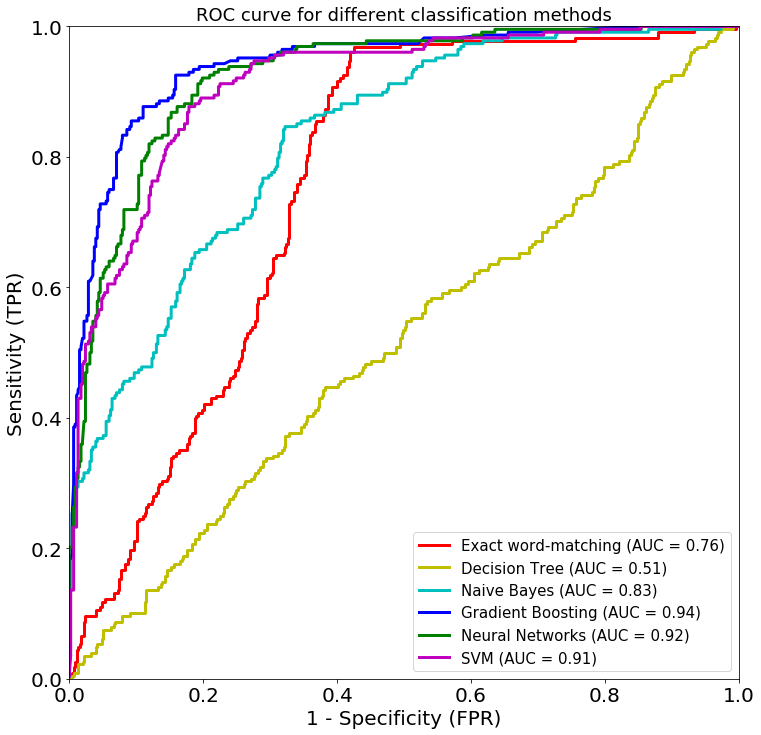

In [35]:
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM']
plt.rcParams.update({'font.size': 20})

filtered_pipe = pipe_list[:3] + pipe_list[4:5]

# Rule Based ->  binarized first (y -> 0; n -> 1)
def binarize(value):
    return int(value != 'y')
if 'y' in list(df_predict['Outcome'].unique()):
    df_predict['Outcome'] = df_predict['Outcome'].apply(lambda x : binarize(x)) 

plt.figure(figsize=(12,12))
append_roc_curve('ROC curve for different classification methods', 'Exact word-matching', fpr_ex, tpr_ex, plt, 'r')

append_roc_curve('ROC curve for different classification methods', 'Decision Tree', fpr_dt, tpr_dt, plt, 'y')

#vis.append_roc_curve('ROC curve for different classification methods', 'Rule based', fpr, tpr, plt)
# ML methods
plt = plot_multi_roc(filtered_pipe[:5],'ROC curve for different classification methods', lbls, X_train, X_test, y_train, y_test)



### Write predictions rule based to csv file

In [34]:
def binarize(value):
    if (value): 
        return 'n'
    else :
        return 'y'

    
df_predict = df_predict.assign(TRUE=df_predict['RA'])
df_predict['TRUE'] = df_predict['TRUE'].apply(lambda x: binarize(x))
df_predict = df_predict.assign(PRED=df_predict['PRED_PROBA'])

df_predict[['TRUE', 'PRED']].to_csv(r'../output_files/predictions/pred' + 'RuleBased' + '.csv', sep='|', index=False)

### Measure time performance
tp_list = time point list (necessary for calculating the standard deviation)

In [103]:
import time
import statistics

print('Training Time (Mean of 100 iterations):\n')
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'Decision Tree', 'SVM', 'Rule based']
tot_it = 100

for x in range(len(lbls)-1): # all methods except for rule based are fitted
    tp_list = []
    t0 = time.time()
    for y in range(tot_it):
        t2 = time.time()
        pipe_list[x].fit(X_train, y_train)
        tp_list.append(time.time() - t2) 
    t1 = time.time()
    total = t1-t0
    print(lbls[x], ' : %0.2f seconds' % (total/tot_it), '\tSTD: %0.2f' % statistics.stdev(tp_list))
    
print('\nTesting Time (Mean of 100 iterations):\n')
for x in range(len(lbls)):
    tp_list = []
    t0 = time.time()
    for y in range(tot_it):
        t2 = time.time()
        if x == len(lbls)-1: # equal to rule based
            cop.predict()
        else :
            pipe_list[x].predict_proba(X_test)[:,1]
        tp_list.append(time.time() - t2) 
    t1 = time.time()
    total = t1-t0
    print(lbls[x], ' : %0.2f seconds' % (total/tot_it), '\tSTD: %0.2f' % statistics.stdev(tp_list))


Training Time (Mean of 100 iterations):

Naive Bayes  : 0.02 seconds 	STD: 0.00
Gradient Boosting  : 0.40 seconds 	STD: 0.01
Neural Networks  : 6.54 seconds 	STD: 0.55
Decision Tree  : 0.03 seconds 	STD: 0.00
SVM  : 0.21 seconds 	STD: 0.00

Testing Time (Mean of 100 iterations):

Naive Bayes  : 0.01 seconds 	STD: 0.00
Gradient Boosting  : 0.01 seconds 	STD: 0.00
Neural Networks  : 0.04 seconds 	STD: 0.01
Decision Tree  : 0.01 seconds 	STD: 0.00
SVM  : 0.05 seconds 	STD: 0.00
Rule based  : 2.57 seconds 	STD: 0.03


## Incorrect predictions

In [61]:
predictions = text_clf.predict(X_test)
for inp, prediction, label in zip(X_test, predictions, y_test):
    if prediction != label:
        print('"', inp, '"\n\n', 'has been classified as ', prediction, 'and should be ', label, '\n') 

" patiente bekend met artroos thans met toenemen pijn en zwelling van handgewricht en knie seronegatief dd artroos ra "

 has been classified as  y and should be  n 

" vrouw jaar ^ acpa rf non erosief ua wv inclusie improved ^ x h v cf eerder geen erosie ^ huidig med geen dmard "

 has been classified as  y and should be  n 

" polyartritis bij sl of toch seronegatief ra wel mtx adalimumab cellceppen aza leflu ritux krijgen aug en sep geen baat plaq mg dd verlagen ivm geen baat en wel risico  nu naar mg ^ verder toenemen duizeligheid en misselijkheid leflunomien ook verlagen naar d mg "

 has been classified as  y and should be  n 

" acpa rf artralgie ^ handartroos "

 has been classified as  y and should be  n 

" sjogr erosief ra wv hcq vanwege intolerantie meerdere dmard na recente opvlamming met artritis mcp zonder progressie van schade nu weer anamnestisch klachtenvrij wat betreffen artritis "

 has been classified as  y and should be  n 

" jarig man met ^ reumatoid artritis kl

# Optional Visualizations

### Visualize Decision Tree - graphviz 
Outputs a file that can be visualized in http://viz-js.com/ 

In [87]:
import graphviz 

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = tree.DecisionTreeClassifier()
test_clf = clf.fit(X_train_tfidf, y_train)

dot_data = tree.export_graphviz(test_clf, out_file=None, feature_names=count_vect.get_feature_names(), class_names=['POSITIVE', 'NEGATIVE'],  
        filled=True, rounded=True, special_characters=True)  
        
graph = graphviz.Source(dot_data) 
graph.save("PredictingRAtree")
#graph.render("Predicting RA diagnosis") 

'Predicting RA diagnosis'

### Visualize Gradient Boosting - graphviz
Outputs a file that can be visualized in http://viz-js.com/ 

In [39]:

import graphviz 

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = ske.GradientBoostingClassifier(n_estimators=50)
test_clf = clf.fit(X_train_tfidf, y_train)
sub_tree_42 = clf.estimators_[1, 0]

dot_data = tree.export_graphviz(
    sub_tree_42,
    out_file=None, feature_names=count_vect.get_feature_names(), class_names=['POSITIVE', 'NEGATIVE'],  
        filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.save("Predicting RA diagnosis GBM")
#graph.render("Predicting RA diagnosis") 

'Predicting RA diagnosis GBM'

### Visualize Learning Curve
To determine the optimal sample size for the trainingsset

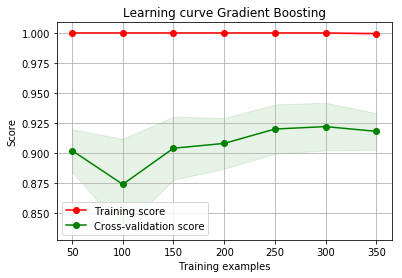

In [64]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

clf = ske.GradientBoostingClassifier(n_estimators=50) # tree.DecisionTreeClassifier(random_state=777)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

plot = vis.plot_learning_curve(clf, 'Learning curve Gradient Boosting', X_train_tfidf, y_train, train_sizes=[50, 100, 150, 200, 250, 300, 350], cv=5)

plot.show()

### Optimize Parameter 

In [89]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3),}
#gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1) # n_jobs -> multiple cores
#gs_clf = gs_clf.fit(X_train, y_train)

In [12]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation

epochs = [5, 10]
batches = [5, 10, 100]
optimizers = ['rmsprop', 'adam']

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 20, 30]},
                    {'kernel': ['linear'], 'C': [1, 10, 20, 30]}]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 20, 30]},
                    {'kernel': ['linear'], 'C': [1, 10, 20, 30]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
0.985 (+/-0.019) for {'C': 20, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 30, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.022) for {'C': 30, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 20, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 30, 'kernel': 'linear'}

Detailed classification report:

The model is traine